<a href="https://colab.research.google.com/github/rjsdn31536/titanic_kaggle/blob/master/titanic_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict survival on the Titanic with ML(Kaggle competition)

## Data 로딩 및 분석

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"

data_train = pd.read_csv(train_file, engine='python')
data_test = pd.read_csv(test_file, engine='python')

data_train.Cabin[339] = 'C'

In [3]:
print(data_train.shape)
print(data_test.shape)

(891, 12)
(418, 11)


In [4]:
display(data_train.head())
display(data_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


#### feature
 - survival : 생존 유무
 - pclass : 티켓 등급
 - sec : 성별
 - age : 나이
 - sibsp : 동승한 형제자매, 배우자 수
 - parch : 동승한 부모, 자녀 수
 - ticket : 티켓 번호
 - cabin : 객실 번호
 - bembarked : 탑승 항구

## Null value 확인

In [5]:
print(data_train.shape)
data_train.isnull().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
print(data_test.shape)
data_test.isnull().sum()

(418, 11)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

확인해보면 age, cabin에 대한 null value가 상당부분 존재한다. 이를 조금 후에 처리해주자
 - Age : Name을 참고하여 결측값 fill
 - Cabin : 다른 feature를 통하여 학습시킨 후에 predict data로 결측값 fill

## Data 분석

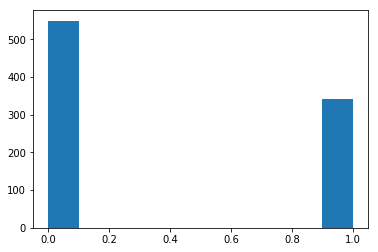

In [7]:
plt.hist(data_train["Survived"])
plt.show()

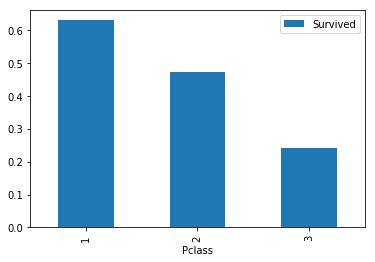

In [8]:
data_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()

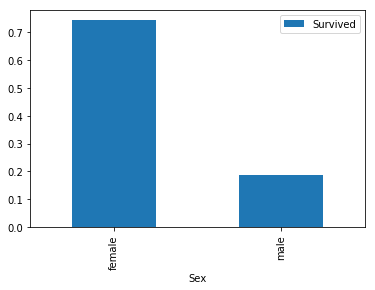

In [9]:
data_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar()

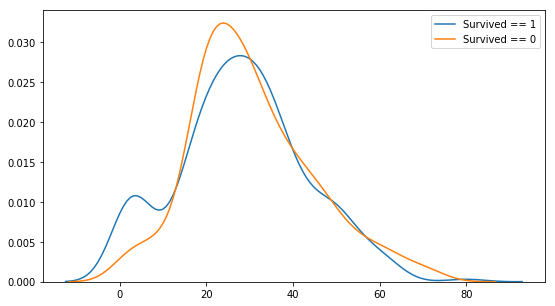

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(data_train[data_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(data_train[data_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

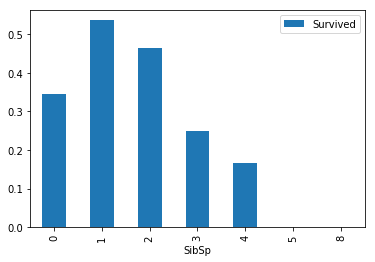

In [11]:
data_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=True).mean().plot.bar()

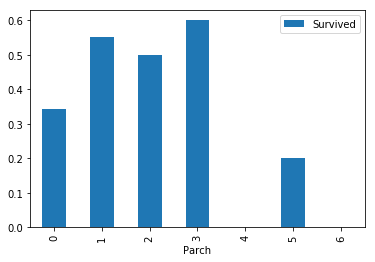

In [12]:
data_train[['Parch', 'Survived']].groupby(['Parch'], as_index=True).mean().plot.bar()

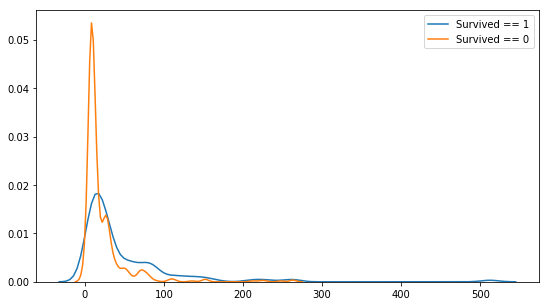

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(data_train[data_train['Survived'] == 1]['Fare'], ax=ax)
sns.kdeplot(data_train[data_train['Survived'] == 0]['Fare'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

## SibSp, Parch merge(To Family)
SibSP는 함께 탑승한 형제자매, 배우자 수 총합 / Parch는 함께 탑승한 부모, 자녀 수 총합이다. <br>
이 두 field를 합쳐 family라는 int형 field를 더 생성하자.

In [14]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
data_train["Family"] = data_train["SibSp"] + data_train["Parch"]
data_test["Family"] = data_test["SibSp"] + data_test["Parch"]

Family가 0인 경우, 즉 가족이 없는 경우의 대한 field를 하나 더 생성해준다. 이를 생성 후에 Survived와 관계가 있는지 확인해보자.

In [16]:
data_train["Alone"] = "Y"
data_train["Alone"].loc[data_train["Family"] > 0] = "N"

data_test["Alone"] = "Y"
data_test["Alone"].loc[data_test["Family"] > 0] = "N"

In [17]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,N
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Y
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,N
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Y


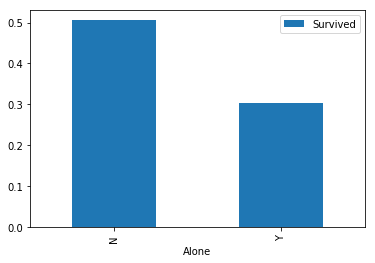

In [18]:
data_train[['Alone', 'Survived']].groupby(['Alone'], as_index=True).mean().plot.bar()

혼자 있으면 생존률이 약 0.3, 가족과 함께 있다면 생존률이 높아지는 것을 확인할 수 있다.

### Cabin 결측치를 예측하여 채우기

In [19]:
data_train['Cabin']

0              NaN
1              C85
2              NaN
3             C123
4              NaN
5              NaN
6              E46
7              NaN
8              NaN
9              NaN
10              G6
11            C103
12             NaN
13             NaN
14             NaN
15             NaN
16             NaN
17             NaN
18             NaN
19             NaN
20             NaN
21             D56
22             NaN
23              A6
24             NaN
25             NaN
26             NaN
27     C23 C25 C27
28             NaN
29             NaN
          ...     
861            NaN
862            D17
863            NaN
864            NaN
865            NaN
866            NaN
867            A24
868            NaN
869            NaN
870            NaN
871            D35
872    B51 B53 B55
873            NaN
874            NaN
875            NaN
876            NaN
877            NaN
878            NaN
879            C50
880            NaN
881            NaN
882         

Cabin은 객실이다. 결측값이 굉장히 많이 존재하지만 생존에 영향을 미치는 feature임을 직감적으로.... 확인할 수 있다. 그럼 눈으로 데이터를 확인해보자.<br>먼저 객실마다의 숫자로 분류하기 보다는 알파벳으로 분류하여 확인해보자.

In [20]:
for i in data_train.index:
  if type(data_train['Cabin'][i]) == str:
    if 'A' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'A'
    if 'B' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'B'
    if 'C' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'C'
    if 'D' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'D'
    if 'E' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'E'
    if 'F' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'F'
    if 'G' in data_train['Cabin'][i]:
      data_train['Cabin'][i] = 'G'
  
for i in data_test.index:
  if type(data_test['Cabin'][i]) == str:
    if 'A' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'A'
    if 'B' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'B'
    if 'C' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'C'
    if 'D' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'D'
    if 'E' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'E'
    if 'F' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'F'
    if 'G' in data_test['Cabin'][i]:
      data_test['Cabin'][i] = 'G'

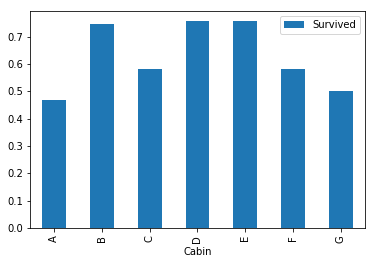

In [21]:
data_train[['Cabin', 'Survived']].groupby(['Cabin'], as_index=True).mean().plot.bar()

확실히 Cabin이 어느정도는 생존에 영향을 미치는 것으로 확인되었다. 그럼 객실은 어떤 특징에 영향을 받을지 생각해보며 다음 시각화된 그래프를 확인해보자.

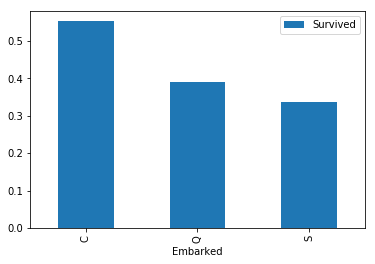

In [22]:
data_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().plot.bar()

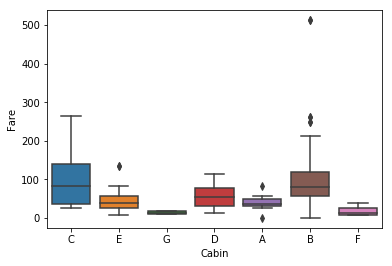

In [23]:
sns.boxplot(x='Cabin', y='Fare', data=data_train)

### Cabin null value 채우기

물론 Cabin을 random 값으로 채우는 방법도 존재하지만 xgboost를 활용하여 cabin을 다른 field로부터 학습하고 값을 채워볼 예정이다.

In [24]:
# 원래의 data가 변경되는 것을 방지하여 tmp에 임시저장
data_train_tmp = data_train
data_test_tmp = data_test

# Cabin이 label이므로 삭제
del_idx = data_train[data_train.Cabin.isnull() == True].index 
data_train = data_train.drop(del_idx, axis = 0)

del_idx = data_test[data_test.Cabin.isnull() == True].index
data_test = data_test.drop(del_idx, axis = 0)

In [25]:
x_train = data_train.drop(['Survived'], axis=1)
x_test = data_test
y_train = x_train['Cabin']
y_test = x_test['Cabin']

In [26]:
x_train = x_train.drop(['Cabin'], axis = 1)
x_test = x_test.drop(['Cabin'], axis = 1)
x_train = x_train.drop(['Name'], axis = 1)
x_test = x_test.drop(['Name'], axis = 1)
x_train = x_train.drop(['PassengerId'], axis = 1)
x_test = x_test.drop(['PassengerId'], axis = 1)
x_train = x_train.drop(['Ticket'], axis = 1)
x_test = x_test.drop(['Ticket'], axis = 1)
display(x_train.head())
display(y_train.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone
1,1,female,38.0,1,0,71.2833,C,1,N
3,1,female,35.0,1,0,53.1000,S,1,N
6,1,male,54.0,0,0,51.8625,S,0,Y
10,3,female,4.0,1,1,16.7000,S,2,N
11,1,female,58.0,0,0,26.5500,S,0,Y


1     C
3     C
6     E
10    G
11    C
Name: Cabin, dtype: object

- x_train, y_train : Cabin을 예측하기 위한 train set

In [27]:
print(x_train.shape)
x_train.isnull().sum()

(204, 9)


Pclass       0
Sex          0
Age         19
SibSp        0
Parch        0
Fare         0
Embarked     2
Family       0
Alone        0
dtype: int64

In [28]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [29]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [30]:
x_train.tail()

,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Alone_N,Alone_Y
871,1,47.0,1,1,52.5542,2,1,0,0,0,1,1,0
872,1,33.0,0,0,5.0000,0,0,1,0,0,1,0,1
879,1,56.0,0,1,83.1583,1,1,0,1,0,0,1,0
887,1,19.0,0,0,30.0000,0,1,0,0,0,1,0,1
889,1,26.0,0,0,30.0000,0,0,1,1,0,0,0,1


In [31]:
x_test.head()

,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Alone_N,Alone_Y
12,1,23.0,1,0,82.2667,1,1,0,0,0,1,1,0
14,1,47.0,1,0,61.1750,1,1,0,0,0,1,1,0
24,1,48.0,1,3,262.3750,4,1,0,1,0,0,1,0
26,1,22.0,0,1,61.9792,1,1,0,1,0,0,1,0
28,1,41.0,0,0,30.5000,0,0,1,0,0,1,0,1


In [32]:
y_train.head()

,A,B,C,D,E,F,G
1,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
6,0,0,0,0,1,0,0
10,0,0,0,0,0,0,1
11,0,0,1,0,0,0,0


In [33]:
y_train_np = np.array(y_train)
y_train_num = np.where(y_train_np == 1)[1]

In [34]:
display(x_train.head())
display(y_train_num)

,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Alone_N,Alone_Y
1,1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0
3,1,35.0,1,0,53.1000,1,1,0,0,0,1,1,0
6,1,54.0,0,0,51.8625,0,0,1,0,0,1,0,1
10,3,4.0,1,1,16.7000,2,1,0,0,0,1,1,0
11,1,58.0,0,0,26.5500,0,1,0,0,0,1,0,1


array([2, 2, 4, 6, 2, 3, 0, 2, 1, 3, 1, 2, 1, 2, 5, 5, 2, 4, 0, 3, 3, 2,
       1, 4, 3, 4, 3, 2, 1, 5, 2, 4, 1, 0, 2, 5, 0, 5, 1, 1, 6, 0, 3, 3,
       2, 2, 2, 3, 6, 2, 1, 4, 1, 2, 2, 2, 3, 0, 1, 3, 2, 2, 1, 4, 2, 2,
       4, 2, 1, 2, 4, 2, 3, 1, 2, 2, 2, 4, 2, 5, 2, 5, 2, 4, 3, 1, 4, 2,
       1, 3, 6, 2, 4, 2, 4, 1, 2, 0, 2, 2, 2, 4, 3, 4, 4, 3, 0, 1, 2, 1,
       2, 3, 2, 1, 2, 4, 3, 5, 1, 1, 2, 1, 1, 1, 2, 2, 0, 4, 2, 4, 4, 2,
       0, 4, 1, 3, 0, 2, 5, 3, 3, 3, 0, 1, 1, 3, 0, 3, 4, 2, 1, 1, 3, 1,
       1, 2, 5, 2, 4, 4, 2, 2, 2, 5, 2, 4, 4, 1, 1, 3, 2, 1, 1, 3, 4, 1,
       1, 3, 4, 5, 1, 1, 3, 1, 3, 1, 0, 4, 1, 1, 4, 1, 4, 2, 2, 3, 4, 3,
       0, 3, 1, 2, 1, 2])

In [35]:
x_train.shape

(204, 13)

In [36]:
y_train_num.shape

(204,)

In [37]:
x_train_tmp = x_train
x_test_tmp = x_test

x_train.drop(["Alone_N"], axis=1, inplace=True)
x_train.drop(["Alone_Y"], axis=1, inplace=True)
x_test.drop(["Alone_N"], axis=1, inplace=True)
x_test.drop(["Alone_Y"], axis=1, inplace=True)
x_train.drop(["Age"], axis=1, inplace=True)
x_test.drop(["Age"], axis=1, inplace=True)

Cabin을 나머지 feature를 이용해 xgb model 사용하여 예측 후 결측치 fill

In [38]:
import xgboost as xgb

model =xgb.XGBClassifier()

# from lightgbm import LGBMClassifier
# model = LGBMClassifier()

model.fit(x_train, y_train_num)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
y_pred = model.predict(x_test)

/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
y_test_np = np.array(y_test)
y_test_num = np.where(y_test_np == 1)[1]

In [41]:
correct_prediction = np.equal(y_pred, y_test_num)

train data와 test(여기서는 valid) data를 확인하여 validation data's accuracy를 구해보니 약 0.57이 나온다. 데이터 수가 너무 적은 탓이다<br>
아주 정확한 결과가 나오지는 않지만, 빈칸을 Cabin의 빈칸을 null로 놔두는것보다는 해당 모델로 predict 해서 fill하는게 낫다고 판단하였다.

In [42]:
len(np.where(correct_prediction ==  True)[0]) / correct_prediction.shape[0]

0.5714285714285714

x_train, y_train 모두 data가 부족하므로 학습시킬때는 valid까지 합쳐서 학습시킨다.

In [43]:
x_train = pd.concat([x_train, x_test])
y_train = pd.concat([y_train, y_test])
y_train_np = np.array(y_train)
y_train_num = np.where(y_train_np == 1)[1]

model.fit(x_train,y_train_num)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
data_train = data_train_tmp
data_test = data_test_tmp

del_idx = data_train[data_train.Cabin.isnull() != True].index 
data_train = data_train.drop(del_idx, axis = 0)

del_idx = data_test[data_test.Cabin.isnull() != True].index
data_test = data_test.drop(del_idx, axis = 0)

In [45]:
y_train = data_train['Survived']
x_train = data_train.drop(['Survived'], axis=1)
x_test = data_test

In [46]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Y
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,N
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Y
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Y
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,N


In [47]:
y_train = x_train['Cabin']
y_test = x_test['Cabin']

In [48]:
x_train = x_train.drop(['Cabin'], axis = 1)
x_test = x_test.drop(['Cabin'], axis = 1)
x_train = x_train.drop(['Name'], axis = 1)
x_test = x_test.drop(['Name'], axis = 1)
x_train = x_train.drop(['PassengerId'], axis = 1)
x_test = x_test.drop(['PassengerId'], axis = 1)
x_train = x_train.drop(['Ticket'], axis = 1)
x_test = x_test.drop(['Ticket'], axis = 1)
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone
0,3,male,22.0,1,0,7.2500,S,1,N
2,3,female,26.0,0,0,7.9250,S,0,Y
4,3,male,35.0,0,0,8.0500,S,0,Y
5,3,male,NaN,0,0,8.4583,Q,0,Y
7,3,male,2.0,3,1,21.0750,S,4,N


In [49]:
print(x_train.shape)
x_train.isnull().sum()

(687, 9)


Pclass        0
Sex           0
Age         158
SibSp         0
Parch         0
Fare          0
Embarked      0
Family        0
Alone         0
dtype: int64

In [50]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [51]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [52]:
x_train.head()

,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Alone_N,Alone_Y
0,3,22.0,1,0,7.2500,1,0,1,0,0,1,1,0
2,3,26.0,0,0,7.9250,0,1,0,0,0,1,0,1
4,3,35.0,0,0,8.0500,0,0,1,0,0,1,0,1
5,3,NaN,0,0,8.4583,0,0,1,0,1,0,0,1
7,3,2.0,3,1,21.0750,4,0,1,0,0,1,1,0


In [53]:
y_train_np = np.array(y_train)
y_train_num = np.where(y_train_np == 1)[1]

In [54]:
x_train.drop(["Alone_N"], axis=1, inplace=True)
x_train.drop(["Alone_Y"], axis=1, inplace=True)
x_test.drop(["Alone_N"], axis=1, inplace=True)
x_test.drop(["Alone_Y"], axis=1, inplace=True)
x_train.drop(["Age"], axis=1, inplace=True)
x_test.drop(["Age"], axis=1, inplace=True)

In [55]:
display(x_train.head())
display(y_train_num)

,Pclass,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,7.2500,1,0,1,0,0,1
2,3,0,0,7.9250,0,1,0,0,0,1
4,3,0,0,8.0500,0,0,1,0,0,1
5,3,0,0,8.4583,0,0,1,0,1,0
7,3,3,1,21.0750,4,0,1,0,0,1


array([], dtype=int64)

In [56]:
y_train_num.shape

(0,)

In [57]:
'''
    pred_train : train data의 cabin 결측치 예측
    pred_test : test data의 cabin 결측치 예측
'''

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
pred_train = pred_train.astype('str')
for i in range(pred_train.shape[0]):
    pred_train[i] = chr(int(pred_train[i]) + ord('A'))
    
pred_test = pred_test.astype('str')
for i in range(pred_test.shape[0]):
    pred_test[i] = chr(int(pred_test[i]) + ord('A'))    

In [59]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,N
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Y
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Y
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,Y
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,4,N


In [60]:
data_train_tmp[data_train_tmp.Cabin.isnull() == True].Cabin = pred_train
data_test_tmp[data_test_tmp.Cabin.isnull() == True].Cabin = pred_test

In [61]:
j=0
for i in (data_train_tmp[data_train_tmp.Cabin.isnull() == True].Cabin.index):
    data_train_tmp.Cabin[i] = pred_train[j]
    j += 1

In [62]:
j=0
for i in (data_test_tmp[data_test_tmp.Cabin.isnull() == True].Cabin.index):
    data_test_tmp.Cabin[i] = pred_test[j]
    j += 1

In [63]:
data_train_tmp.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,F,S,1,N
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,N
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,E,S,0,Y
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,N
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,E,S,0,Y


In [64]:
data_train = data_train_tmp
data_test = data_test_tmp

In [65]:
print(data_train.isnull().sum())
print(data_train.shape, '\n')
print(data_test.isnull().sum())
print(data_test.shape)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
Family           0
Alone            0
dtype: int64
(891, 14) 

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin           0
Embarked        0
Family          0
Alone           0
dtype: int64
(418, 13)


### 필요없는 field 제거

In [66]:
data_train = data_train.drop(['PassengerId'], axis = 1)
data_test = data_test.drop(['PassengerId'], axis = 1)

data_train = data_train.drop(['Ticket'], axis = 1)
data_test = data_test.drop(['Ticket'], axis = 1)

In [67]:
y_train = data_train['Survived']
x_train = data_train.drop(['Survived'], axis=1)

x_test = data_test

In [68]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Alone
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,F,S,1,N
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,1,N
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,E,S,0,Y
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,1,N
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,E,S,0,Y


In [69]:
set(x_train.Parch)

{0, 1, 2, 3, 4, 5, 6}

아래 코드는 SibSp와 Parch가 사람의 수이기 때문에, categorical data에 더욱 가깝다 생각하여 넣었지만 grade는 더 낮게 나와 제거하였다.

In [70]:
# x_test.Parch[x_test.Parch == 9] = 6

# # SibSp는 categorical data이므로 str로 변환 후 dummy data로 변경시켜야 함.
# x_train["SibSp"] = x_train["SibSp"].astype('str')
# x_test["SibSp"] = x_test["SibSp"].astype('str')

# # Parch는 categorical data이므로 str로 변환 후 dummy data로 변경시켜야 함.
# x_train["Parch"] = x_train["Parch"].astype('str')
# x_test["Parch"] = x_test["Parch"].astype('str')

# # Pclass는 categorical data이므로 str로 변환 후 dummy data로 변경시켜야 함.
# x_train["Pclass"] = x_train["Pclass"].astype('str')
# x_test["Pclass"] = x_test["Pclass"].astype('str')

In [71]:
x_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family,Alone
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,F,Q,0,Y
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,F,S,1,N
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,E,Q,0,Y
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,E,S,0,Y
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,G,S,2,N


### Fare 결측치(test set에 하나만 존재)
 - mean값으로 대체한다.

In [72]:
x_test.Fare = x_test.Fare.fillna(x_test.Fare.mean())

### Age 결측치

Age는 Name에서 Mr는 약 40살, Miss는 약 10살 등으로 간략하게 유추가 가능하다. 이를 활용해 Age의 결측치를 채워보자.

In [73]:
tt = set()
for i in x_train[x_train['Age'].isnull() == True].index:
    tmp = x_train['Name'][i].split(", ")
    tmp = tmp[1].split('.')
    tt.add(tmp[0])
print(tt)

{'Dr', 'Mrs', 'Master', 'Miss', 'Mr'}


In [74]:
for i in x_train[x_train['Age'].isnull() == True].index:
    tmp = x_train['Name'][i].split(", ")
    tmp = tmp[1].split('.')
    if tmp[0] == 'Master':
        x_train['Age'][i] = 9
    if tmp[0] == 'Miss':
        x_train['Age'][i] = 10
    if tmp[0] == 'Mr':
        x_train['Age'][i] = 40
    if tmp[0] == 'Mrs':
        x_train['Age'][i] = 40
    if tmp[0] == 'Dr':
        x_train['Age'][i] = 40

In [75]:
tt = set()
for i in x_test[x_test['Age'].isnull() == True].index:
    tmp = x_test['Name'][i].split(", ")
    tmp = tmp[1].split('.')
    tt.add(tmp[0])
print(tt)

{'Ms', 'Mrs', 'Master', 'Miss', 'Mr'}


In [76]:
for i in x_test[x_test['Age'].isnull() == True].index:
    tmp = x_test['Name'][i].split(", ")
    tmp = tmp[1].split('.')
    if tmp[0] == 'Master':
        x_test['Age'][i] = 9
    elif tmp[0] == 'Miss':
        x_test['Age'][i] = 10
    elif tmp[0] == 'Mr':
        x_test['Age'][i] = 40
    elif tmp[0] == 'Mrs':
        x_test['Age'][i] = 40
    elif tmp[0] == 'Ms':
        x_test['Age'][i] = 30
    else:
        print(i)

### Age grouping
continuous 한 데이터를 categorical 데이터로 바꾸어주는 과정이다. 이대로 데이터를 모델에 집어넣어도 크게 상관은 없다. 한가지 방법일 뿐이다.
continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있다고 한다.

In [77]:
x_train["Age_cat"] = "60_"
x_train["Age_cat"].loc[x_train["Age"] < 60] = "50_60"
x_train["Age_cat"].loc[x_train["Age"] < 50] = "40_50"
x_train["Age_cat"].loc[x_train["Age"] < 40] = "30_40"
x_train["Age_cat"].loc[x_train["Age"] < 30] = "20_30"
x_train["Age_cat"].loc[x_train["Age"] < 20] = "10_20"
x_train["Age_cat"].loc[x_train["Age"] < 10] = "0_10"

x_test["Age_cat"] = "60_"
x_test["Age_cat"].loc[x_test["Age"] < 60] = "50_60"
x_test["Age_cat"].loc[x_test["Age"] < 50] = "40_50"
x_test["Age_cat"].loc[x_test["Age"] < 40] = "30_40"
x_test["Age_cat"].loc[x_test["Age"] < 30] = "20_30"
x_test["Age_cat"].loc[x_test["Age"] < 20] = "10_20"
x_test["Age_cat"].loc[x_test["Age"] < 10] = "0_10"

x_train.drop(["Age"], axis = 1, inplace = True)
x_test.drop(["Age"], axis = 1, inplace = True)

In [78]:
y_train.shape

(891,)

### Skew data 처리(box-cox transformation)

In [79]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = x_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    x_train[feat] = boxcox1p(x_train[feat], lam)


Skew in numerical features: 

There are 5 skewed numerical features to Box Cox transform


In [80]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = x_test.dtypes[x_test.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = x_test[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    x_test[feat] = boxcox1p(x_test[feat], lam)


Skew in numerical features: 

There are 5 skewed numerical features to Box Cox transform


In [81]:
x_train.drop(["Name"], axis = 1, inplace = True)
x_test.drop(["Name"], axis = 1, inplace = True)

In [82]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

### 최종 데이터 셋

In [83]:
x_train.head()

,Pclass,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Alone_N,Alone_Y,Age_cat_0_10,Age_cat_10_20,Age_cat_20_30,Age_cat_30_40,Age_cat_40_50,Age_cat_50_60,Age_cat_60_
0,1.540963,0.730463,0.0,2.482401,0.730463,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
1,0.730463,0.730463,0.0,6.002978,0.730463,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
2,1.540963,0.000000,0.0,2.590967,0.000000,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0.730463,0.730463,0.0,5.464102,0.730463,1,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
4,1.540963,0.000000,0.0,2.610301,0.000000,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [84]:
x_train.head()

,Pclass,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Alone_N,Alone_Y,Age_cat_0_10,Age_cat_10_20,Age_cat_20_30,Age_cat_30_40,Age_cat_40_50,Age_cat_50_60,Age_cat_60_
0,1.540963,0.730463,0.0,2.482401,0.730463,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
1,0.730463,0.730463,0.0,6.002978,0.730463,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
2,1.540963,0.000000,0.0,2.590967,0.000000,1,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,0.730463,0.730463,0.0,5.464102,0.730463,1,0,0,0,1,...,1,1,0,0,0,0,1,0,0,0
4,1.540963,0.000000,0.0,2.610301,0.000000,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


## model 선정 및 학습

In [85]:
from sklearn.linear_model import LogisticRegression
from subprocess import check_output
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

model1 = GradientBoostingClassifier()
model2 =RandomForestClassifier()
model3 =XGBClassifier(
    learning_rate =0.01,
    n_estimators=10000,
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.7,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    seed=27
)
model4 = LGBMClassifier()
model5 = MLPClassifier()




clf = VotingClassifier(estimators=
                       [('GBC', model1),
                        ('RF', model2),
                        ('XGB', model3),
                        ('LGBM', model4),
                        ('MLP', model5)
                                ])

/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [86]:
clf.fit(x_train, y_train)

VotingClassifier(estimators=[('GBC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1,...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [87]:
a = clf.predict(x_test)

/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [88]:
submission = pd.DataFrame()
submission['PassengerId'] = x_test.index+892
submission['Survived'] = a
print(submission)
submission.to_csv('./output_csv/pred.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         0
19           911         1
20           912         0
21           913         1
22           914         1
23           915         1
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
3

### k-fold cross validation으로 제대로 검증

In [89]:
from sklearn.cross_validation import cross_val_score


model_list = [model1, model2, model3, model4, model5, clf]
# model_list = [clf]

j = 0
for i in model_list:
    j+=1
    print(j, str(i).split('(')[0])
    scores = cross_val_score(estimator=i, 
                             X=x_train, 
                             y=y_train, 
                             cv=5,
                             n_jobs=1)
    print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f\n' % (np.mean(scores), np.std(scores)))

/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


1 GradientBoostingClassifier
CV accuracy scores: [0.83240223 0.79888268 0.84269663 0.81460674 0.84180791]
CV accuracy: 0.826 +/- 0.017

2 RandomForestClassifier
CV accuracy scores: [0.79329609 0.7877095  0.8258427  0.79775281 0.84745763]
CV accuracy: 0.810 +/- 0.023

3 XGBClassifier


/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

CV accuracy scores: [0.81005587 0.81564246 0.87078652 0.8258427  0.82485876]
CV accuracy: 0.829 +/- 0.021

4 LGBMClassifier
CV accuracy scores: [0.82681564 0.7877095  0.85393258 0.82022472 0.84180791]
CV accuracy: 0.826 +/- 0.022

5 MLPClassifier
CV accuracy scores: [0.7877095  0.80446927 0.82022472 0.82022472 0.84745763]
CV accuracy: 0.816 +/- 0.020

6 VotingClassifier


/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

CV accuracy scores: [0.82681564 0.81564246 0.87640449 0.8258427  0.84180791]
CV accuracy: 0.837 +/- 0.021



/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/airi/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### MLP(tensorflow)

In [90]:
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

#### hyperparameter init

In [91]:
'''
    hidden_layer1 : hidden layer의 뉴런 개수
    keepout : keepout rate
    step : 학습 횟수
    learning_rate : optimizer learning rate
'''
hidden_layer1 = 20
hidden_layer2 = 10
keepout = 0.5
step = 10000
learning_rate = 0.0002
batch_size = 30

#### Model

In [92]:
'''
    y_ : Input labels
    keep_prob : keepout rate
'''
y_ = tf.placeholder(tf.float32, [None,2])
keep_prob = tf.placeholder(tf.float32)

# weight, bias
W1 = tf.Variable(tf.truncated_normal([x_train.shape[1], hidden_layer1], stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape = [hidden_layer1]))

# weight, bias
W2 = tf.Variable(tf.truncated_normal([hidden_layer1, hidden_layer2], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape = [hidden_layer2]))

W0 = tf.Variable(tf.truncated_normal([hidden_layer2, 2], stddev=0.1))
b0 = tf.Variable(tf.constant(0.1, shape = [2]))

# Input layer
x1 = tf.placeholder(tf.float32, [None, x_train.shape[1]])

# Hidden layer 1
hidden1 = tf.nn.relu(tf.matmul(x1, W1) + b1)
hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
# Hidden layer 2
hidden2 = tf.nn.relu(tf.matmul(hidden1_drop, W2) + b2)
hidden2_drop = tf.nn.dropout(hidden2, keep_prob)

# Output layer(Labels_predict)
k = tf.matmul(hidden2_drop, W0) + b0
p = tf.nn.softmax(k)
label = tf.argmax(p, 1)

'''
    cost func : MSE
    optimizer : adam
'''
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = k,labels = y_)) 
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [93]:
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [94]:
y_train = pd.get_dummies(y_train)

In [95]:
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, test_size=0.33, random_state=7)

In [96]:
x_train1.head()

,Pclass,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,...,Embarked_S,Alone_N,Alone_Y,Age_cat_0_10,Age_cat_10_20,Age_cat_20_30,Age_cat_30_40,Age_cat_40_50,Age_cat_50_60,Age_cat_60_
65,1.540963,0.730463,0.730463,3.461245,1.194318,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
445,0.730463,0.000000,1.194318,6.265138,1.194318,0,1,1,0,0,...,1,1,0,1,0,0,0,0,0,0
659,0.730463,0.000000,1.194318,6.904008,1.194318,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
591,0.730463,0.730463,0.000000,6.179465,0.730463,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
690,0.730463,0.730463,0.000000,5.591427,0.730463,0,1,0,1,0,...,1,1,0,0,0,0,1,0,0,0


In [97]:
# prepare session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# tensorboard를 사용하기 위하여 summary.scalar를 사용
tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./tensorboard', sess.graph)

i=0
for _ in range(step):
    i += 1
    __, loss = sess.run([train_step, cost],
             feed_dict={y_: y_train1, x1:x_train1, keep_prob : keepout})
    accu = sess.run(accuracy, feed_dict={y_ : y_train1, x1 : x_train1, keep_prob : 1})
    val_accu = sess.run(accuracy, feed_dict={y_ : y_train2, x1 : x_train2, keep_prob : 1})
    summary = sess.run(merged, feed_dict={y_ : y_train2, x1 : x_train2, keep_prob:keepout})
    train_writer.add_summary(summary, i)
    if i % 100 == 0:
        print("{}epoch - loss : {}, accuracy : {}, val_accuracy : {}".format(_+1, loss, accu, val_accu))
train_writer.close()

100epoch - loss : 0.6761167645454407, accuracy : 0.6258389353752136, val_accuracy : 0.5966101884841919
200epoch - loss : 0.6554861068725586, accuracy : 0.6258389353752136, val_accuracy : 0.5966101884841919
300epoch - loss : 0.6135455965995789, accuracy : 0.6459731459617615, val_accuracy : 0.6135593056678772
400epoch - loss : 0.5720095634460449, accuracy : 0.7432885766029358, val_accuracy : 0.6711864471435547
500epoch - loss : 0.5566237568855286, accuracy : 0.7768456339836121, val_accuracy : 0.7288135886192322
600epoch - loss : 0.49457821249961853, accuracy : 0.7986577153205872, val_accuracy : 0.7423728704452515
700epoch - loss : 0.4683046340942383, accuracy : 0.8070470094680786, val_accuracy : 0.7694915533065796
800epoch - loss : 0.465782105922699, accuracy : 0.8221476674079895, val_accuracy : 0.7694915533065796
900epoch - loss : 0.46033212542533875, accuracy : 0.8271812200546265, val_accuracy : 0.7728813290596008
1000epoch - loss : 0.4470551311969757, accuracy : 0.8305369019508362, va

8000epoch - loss : 0.3030770421028137, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8100epoch - loss : 0.29688048362731934, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8200epoch - loss : 0.28359511494636536, accuracy : 0.9010066986083984, val_accuracy : 0.7728813290596008
8300epoch - loss : 0.30344730615615845, accuracy : 0.9010066986083984, val_accuracy : 0.7728813290596008
8400epoch - loss : 0.30445945262908936, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8500epoch - loss : 0.3055495023727417, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8600epoch - loss : 0.30640119314193726, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8700epoch - loss : 0.3099013864994049, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8800epoch - loss : 0.3168174922466278, accuracy : 0.9010066986083984, val_accuracy : 0.7762711644172668
8900epoch - loss : 0.30533137917518616, accuracy : 0.901006

In [98]:
pred = sess.run(label, feed_dict={x1 : x_test, keep_prob : 1})
sess.close()

In [99]:
submission = pd.DataFrame()
submission['PassengerId'] = x_test.index+892
submission['Survived'] = pred
print(submission)
submission.to_csv('./output_csv/MLP_pred.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         0
16           908         0
17           909         0
18           910         0
19           911         1
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         0
3